## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [3]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
# ks = list(range(11))
ks = list(range(6))
step_sizes = [2**k for k in ks]
print(step_sizes)

[1, 2, 4, 8, 16, 32]


### load data & models

In [4]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [83]:
#load models
models = list()
for step_size in step_sizes:
    for i in range(4):
        print('model_D{}_noise0.0_{}.pt'.format(step_size, i))
        models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_{}.pt'.format(step_size, i)), map_location='cpu'))
    
print(models)

model_D1_noise0.0_0.pt
model_D1_noise0.0_1.pt
model_D1_noise0.0_2.pt
model_D1_noise0.0_3.pt
model_D2_noise0.0_0.pt
model_D2_noise0.0_1.pt
model_D2_noise0.0_2.pt
model_D2_noise0.0_3.pt
model_D4_noise0.0_0.pt
model_D4_noise0.0_1.pt
model_D4_noise0.0_2.pt
model_D4_noise0.0_3.pt
model_D8_noise0.0_0.pt
model_D8_noise0.0_1.pt
model_D8_noise0.0_2.pt
model_D8_noise0.0_3.pt
model_D16_noise0.0_0.pt
model_D16_noise0.0_1.pt
model_D16_noise0.0_2.pt
model_D16_noise0.0_3.pt
model_D32_noise0.0_0.pt
model_D32_noise0.0_1.pt
model_D32_noise0.0_2.pt
model_D32_noise0.0_3.pt
[ResNet(
  (activation): ReLU()
  (increment): NNBlock(
    (activation): ReLU()
    (Linear_0): Linear(in_features=2, out_features=128, bias=True)
    (Linear_1): Linear(in_features=128, out_features=128, bias=True)
    (Linear_2): Linear(in_features=128, out_features=128, bias=True)
    (Linear_3): Linear(in_features=128, out_features=2, bias=True)
  )
), ResNet(
  (activation): ReLU()
  (increment): NNBlock(
    (activation): ReLU()


C:\Users\16kat\OneDrive - acornonsite.com\Documents\Fall 2020\multiscale_HiTS\src\ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
No handles with labels found to put in legend.


(array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

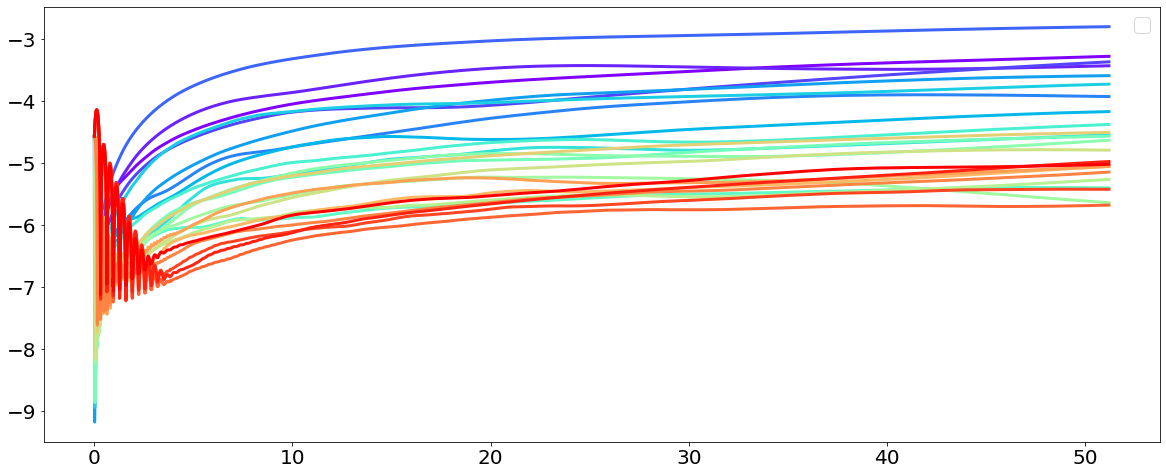

In [84]:
# find mse for each model and plot
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

preds_mse = list()
times = list()

# plt.figure()
for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1).numpy())

#     print(y_preds)
#     plt.plot(y_preds[0,:,:])
# plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
print(colors)
err_list = list()
for k in range(len(models)):
    err = preds_mse[k]
    err_list.append(err)
    mean = err.mean(0)#.detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0)#, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(320, 5121, 2)


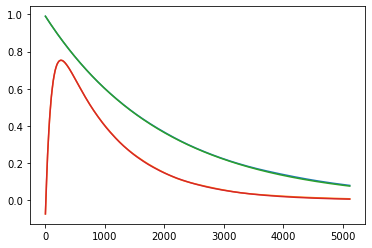

In [82]:
print(test_data.shape)
i = 0
plt.plot(y_preds[i,:,:])
plt.plot(test_data[i,:,:])

In [64]:
print(np.array(preds_mse).shape)
print( test_data.shape[1])
print(np.array(err_list).shape)

(4, 320, 5120)
5121
(4, 320, 5120)


[          nan 5.1053504e-09 1.1004494e-08 ... 5.6931132e-04 5.6932587e-04
 5.6934083e-04]


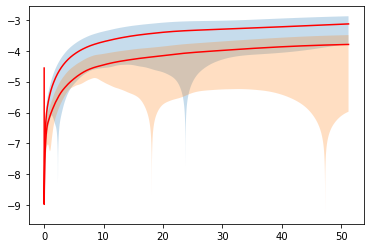

In [67]:
err_list = np.array(err_list)
mean_all_2 = err_list.mean(axis=(0,1))
std_all_2 = err_list.std(axis=(0,1))
print(std_all)
# plt.errorbar(t, np.log10(mean_all), np.log10(std_all))
plt.fill_between(t, np.log10(abs(mean_all_1-std_all_1)), np.log10(abs(mean_all_1+std_all_1)), alpha = 0.25)
plt.fill_between(t, np.log10(abs(mean_all_2-std_all_2)), np.log10(abs(mean_all_2+std_all_2)), alpha = 0.25)
plt.plot(t, np.log10(mean_all_1), 'r')
plt.plot(t, np.log10(mean_all_2), 'r')


# plt.plot(t,std_all)
# plt.plot(t, mean_all)

In [50]:
print(std_all[1000])
print(mean_all[1000])
print(np.log10(-std_all[1000] + mean_all[1000]))

0.00022420414
0.00019659556
nan


<ipython-input-50-043c068cbb85>:3: RuntimeWarning: invalid value encountered in log10
  print(np.log10(-std_all[1000] + mean_all[1000]))


In [5]:
# # load models
# models = list()
# for step_size in step_sizes:
#     print('load model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))
    
# models_b = list()
# for step_size in step_sizes:
#     print('load model_D{}_b.pt'.format(step_size))
#     models_b.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_b.pt'.format(step_size)), map_location='cpu'))
    
# models_c = list()
# for step_size in step_sizes:
#     print('load model_D{}_c.pt'.format(step_size))
#     models_c.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_c.pt'.format(step_size)), map_location='cpu'))
    
# models_d = list()
# for step_size in step_sizes:
#     print('load model_D{}_d.pt'.format(step_size))
#     models_d.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_d.pt'.format(step_size)), map_location='cpu'))

# # fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D1_b.pt
load model_D2_b.pt
load model_D4_b.pt
load model_D8_b.pt
load model_D16_b.pt
load model_D32_b.pt
load model_D1_c.pt
load model_D2_c.pt
load model_D4_c.pt
load model_D8_c.pt
load model_D16_c.pt
load model_D32_c.pt
load model_D1_d.pt
load model_D2_d.pt
load model_D4_d.pt
load model_D8_d.pt
load model_D16_d.pt
load model_D32_d.pt


### benchmarks

In [6]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

C:\Users\16kat\OneDrive - acornonsite.com\Documents\Fall 2020\multiscale_HiTS\src\ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


C:\Users\16kat\OneDrive - acornonsite.com\Documents\Fall 2020\multiscale_HiTS\src\ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


C:\Users\16kat\OneDrive - acornonsite.com\Documents\Fall 2020\multiscale_HiTS\src\ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


C:\Users\16kat\OneDrive - acornonsite.com\Documents\Fall 2020\multiscale_HiTS\src\ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


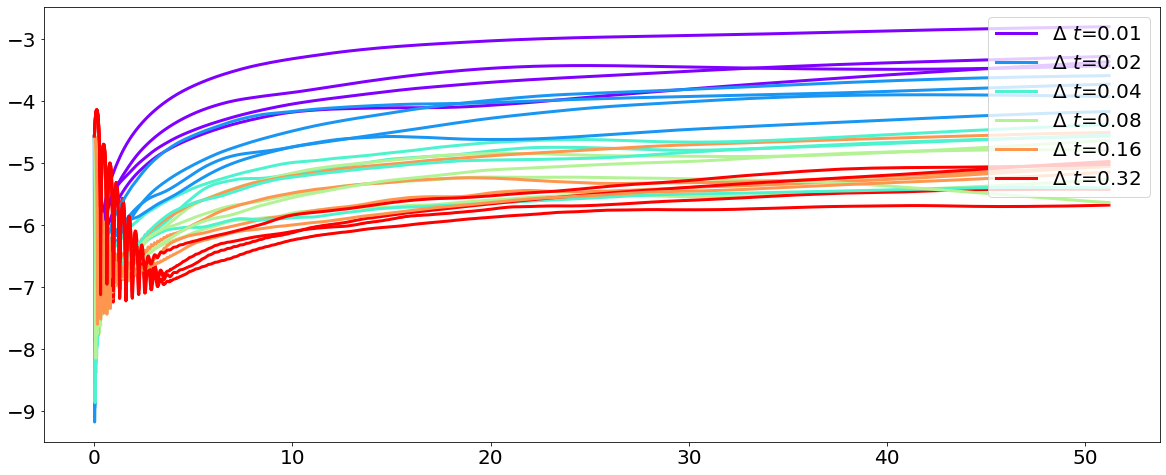

In [7]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
print(colors)
for k in range(len(ks)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#for the b models
preds_mse1 = list()
times1 = list()
for model in tqdm(models_b):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times1.append(end - start)
    preds_mse1.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(ks)):
    err = preds_mse1[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))

    
#for the c models    
preds_mse2 = list()
times2 = list()
for model in tqdm(models_c):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times2.append(end - start)
    preds_mse2.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(ks)):
    err = preds_mse2[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))

#for the d models
preds_mse3 = list()
times3 = list()
for model in tqdm(models_d):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times3.append(end - start)
    preds_mse3.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(ks)):
    err = preds_mse3[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))

    

In [8]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0



use models 1 - 6.


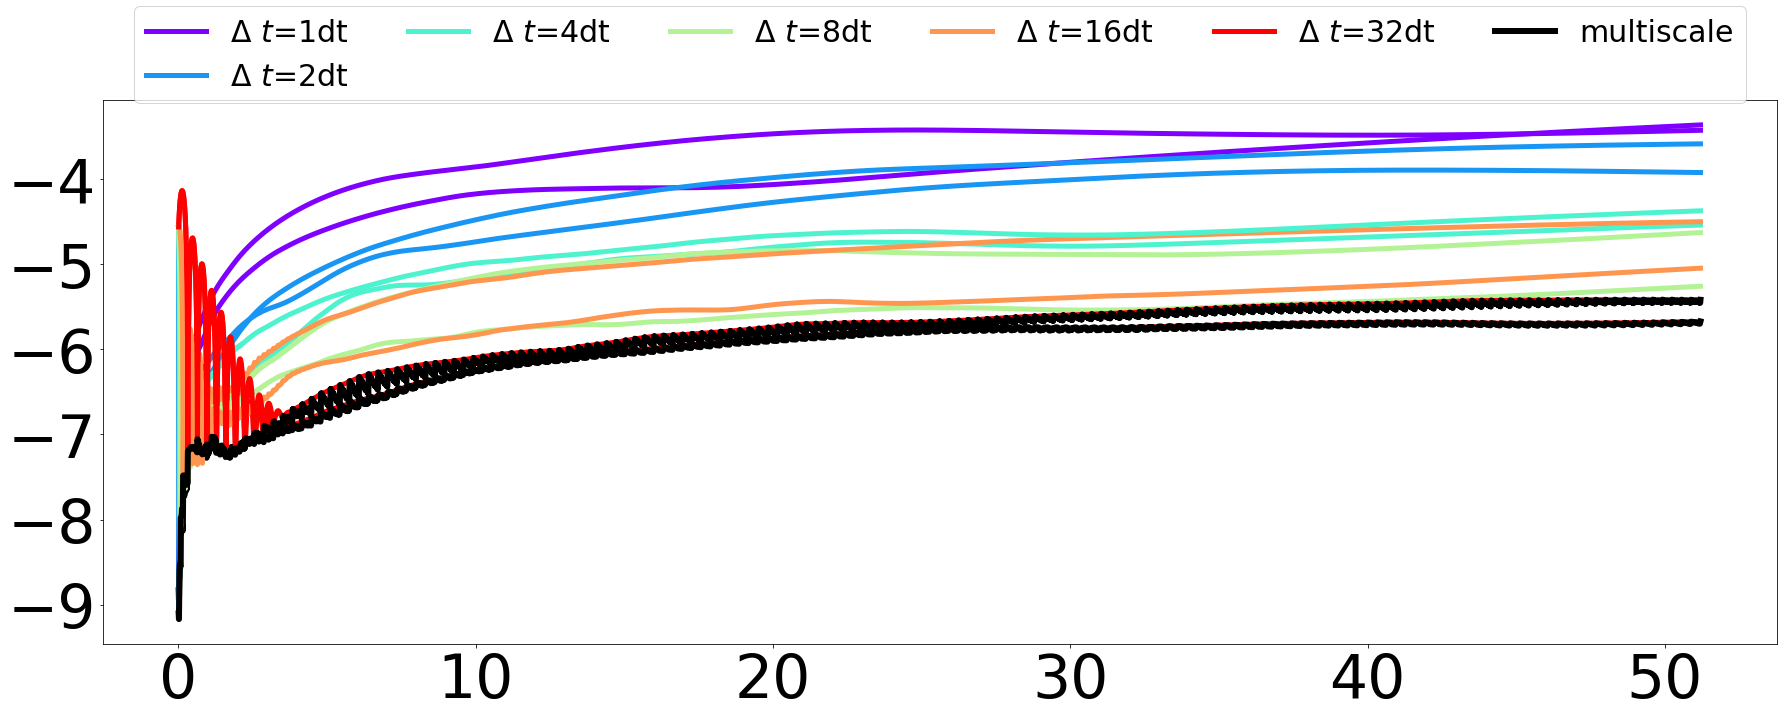

In [9]:
# multiscale time-stepping with NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(ks)):#len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

# multiscale time-stepping with NN
start = time.time()
y_preds1 = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models_b)
end = time.time()
# multiscale_time = end - start
multiscale_preds_mse1 = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds1).mean(-1)

# visualize forecasting error at each time step    
# fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err1 = multiscale_preds_mse1.mean(0).detach().numpy()
for k in range(len(ks)):#len(preds_mse)):
    err = preds_mse1[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err1), linestyle='-', color='k', linewidth=6, label='multiscale')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)

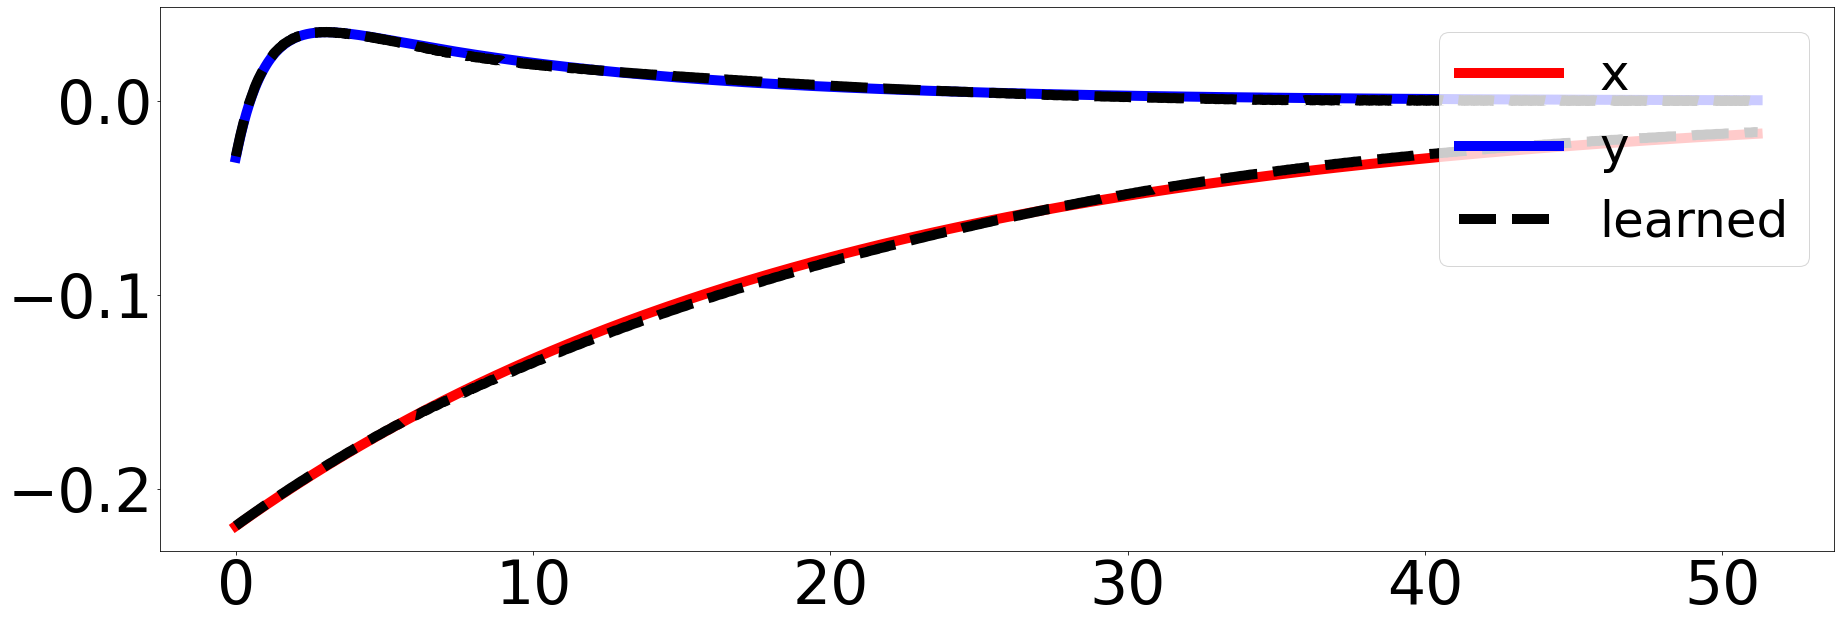

In [10]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 15
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [11]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))

single scaled model (Dt=0.01): computing time 7.487056493759155s
single scaled model (Dt=0.02): computing time 3.206102132797241s
single scaled model (Dt=0.04): computing time 1.640629768371582s
single scaled model (Dt=0.08): computing time 0.8637096881866455s
single scaled model (Dt=0.16): computing time 0.43982625007629395s
single scaled model (Dt=0.32): computing time 0.33310699462890625s
ensembled multiscale model: computing time 1.2907042503356934s


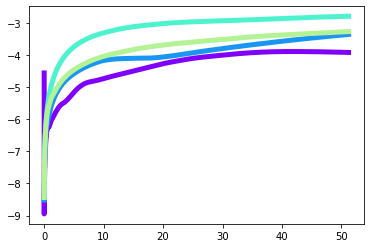

In [19]:
# i = 0
# #for the d models
# preds_mse_each = list()
# for j in range(4):
#     if j == 0:
#         model = models[i]
#     elif j == 1:
#         model = models_b[i]
#     elif j == 2:
#         model = models_c[i]
#     else:
#         model = models_d[i]
#     y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     preds_mse_each.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# for j in range(4):
err = preds_mse_each[j]
mean = err.mean(0).detach().numpy()
rgb = next(colors)
plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    
# preds_mse3 = list()
# times3 = list()
# for model in tqdm(models_d):
#     start = time.time()
#     y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     end = time.time()
#     times3.append(end - start)
#     preds_mse3.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    

In [22]:
print(len(preds_mse_each))
print(len(preds_mse_each[0]))

4
320
